In [1]:
import folium
import pandas as pd
import pickle
import os
import h3
from label_samples_time_hexa import label_samples
from vizualize import *
from func import *

In [2]:
matrix = pd.read_pickle("/home/jaro/BINP29/Project_Eran/1_dist_matrix/eucl_dist.pkl")

In [3]:
time_bins = 18
resolution = 3
same_age_range = True
df = label_samples("/home/jaro/BINP29/Project_Eran/", time_bins, resolution, same_age_range)
time_bins = rename_time_bins(df)
time_bins_hexagons = get_time_bin_hexagons(df)

In [4]:
# calculate the average distances between neighboring hexagons for each time bin with the given parameters
time_bins_dist = calc_dist_time_bin(df, matrix,
                                        7,
                                        False)

In [5]:
selected_time_bin = time_bins[1]
hexagons = time_bins_hexagons[selected_time_bin]
time_bin = time_bins_dist[selected_time_bin]
time_bin = normalize_distances(time_bin)
threshold = 0.4

In [6]:
isolated_hex, barrier_lines, barrier_hex = get_isolated_hex_and_barriers(time_bin, hexagons, 10, threshold)

print(f"Number of isolated hexagons: {len(isolated_hex)}")
print(f"Number of barrier lines: {len(barrier_lines)}")
print(f"Number of barrier hexagons: {len(barrier_hex)}")

Number of isolated hexagons: 15
Number of barrier lines: 171
Number of barrier hexagons: 960


In [7]:
# get the index of the time bin of interest
time_bin = time_bins.index(time_bins[1])
# get the closest population for each isolated hexagon
closest_populations, new_isolated_hex = find_closest_population(df, time_bin, isolated_hex, matrix, threshold)
print(f"Number of isolated hexagons with no migration: {len(new_isolated_hex)}")

Number of isolated hexagons with no migration: 1


In [8]:
imputed_hex = impute_missing_hexagons_multiple_runs(barrier_hex, hexagons, num_runs=8)
len(imputed_hex)

1212

In [ ]:
m = draw_sample_hexagons(hexagons)
m = draw_hexagons(new_isolated_hex, color = "red", m = m, opacity=0.7, value="No migration")
m = draw_migration_for_time_bin(closest_populations, m)
m = draw_hexagons_with_values(barrier_hex, m, threshold = 0.0)
m = draw_hexagons_with_values(imputed_hex, m, threshold = 0.0, imputed=True)
m = draw_barriers(barrier_lines, m)

m

In [ ]:
# create a new hexagon with res 0 at 0,0
parent = h3.geo_to_h3(39.28715198232231, 41.751540592745535,0)
# get all hexagons from the hexagons list that are within the parent hexagon
chosen = [hex for hex in hexagons if h3.h3_to_parent(hex,0) == parent]
distance_hex = set()
for hex1 in chosen:
    for i in range(1,8):
        neighbors = h3.k_ring_distances(hex1, i)[i]
        neighbors = [n for n in neighbors if n in chosen]
        for hex2 in neighbors:
            try:
                line_hex = h3.h3_line(hex1, hex2)[1:-1]
                # add the hexagons from line_hex to the set of distance_hex
                distance_hex.update(line_hex)
            except:
                pass
            
print(distance_hex)


In [ ]:
m = draw_sample_hexagons(hexagons, color="red")
# m = draw_sample_hexagons(distance_hex, color="blue", m=m)
m

In [6]:
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

# get the centroid of every hexagon
coord = []
for hex in hexagons:
    coord.append(h3.h3_to_geo(hex))
# change coord to np array
coord = np.array(coord)
hexagons = np.array(hexagons)
len(coord)




253

In [7]:
tri = Delaunay(coord)
print(tri.simplices)


[[207 162  19]
 [162 206 196]
 [208 209 196]
 ...
 [ 70  67 246]
 [244  67 146]
 [ 67 250 146]]


In [8]:
def tris2edges(tris):
    edges = set([])
    for tri in tris:
        for k in range(3):
            i,j = tri[k], tri[(k+1)%3]
            i,j = min(i,j), max(i,j)  # canonical edge representation
            edges.add((i,j))
    return edges
            
edges = tris2edges(tri.simplices)
print(edges)

{(177, 181), (99, 100), (115, 215), (159, 160), (8, 9), (22, 145), (34, 147), (117, 163), (40, 50), (25, 196), (20, 230), (132, 133), (156, 252), (201, 251), (192, 193), (184, 189), (96, 216), (62, 74), (118, 225), (243, 247), (44, 47), (172, 205), (101, 163), (205, 239), (18, 156), (125, 130), (14, 15), (225, 226), (90, 181), (122, 124), (106, 107), (95, 107), (68, 242), (122, 133), (166, 167), (202, 251), (5, 222), (15, 16), (226, 227), (47, 48), (92, 236), (55, 61), (81, 217), (199, 200), (121, 128), (140, 141), (4, 235), (73, 78), (125, 134), (22, 23), (29, 148), (205, 252), (19, 134), (74, 79), (198, 203), (58, 229), (81, 194), (177, 180), (88, 90), (55, 56), (147, 148), (139, 144), (28, 66), (207, 208), (81, 221), (201, 232), (121, 123), (57, 120), (32, 185), (40, 49), (140, 145), (20, 238), (151, 154), (62, 64), (213, 224), (240, 241), (184, 188), (131, 163), (194, 219), (87, 93), (95, 106), (114, 119), (26, 235), (27, 209), (247, 249), (76, 83), (96, 98), (53, 127), (49, 84), (

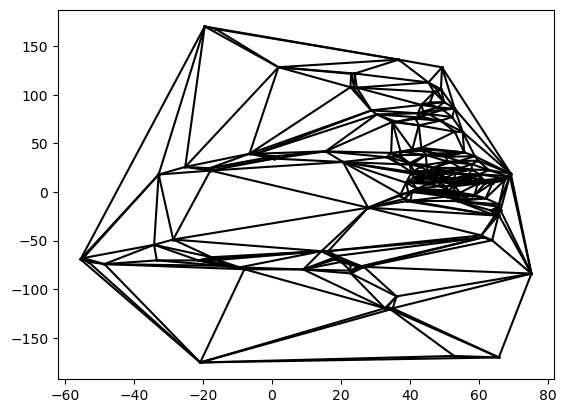

In [62]:
# visualize all the centroids on a simple x and y plot and draw the edges
plt.scatter(*zip(*coord), s=1, c="black")
for (i,j) in edges:
    xi = coord[i][0]
    xj = coord[j][0]
    yi = coord[i][1]
    yj = coord[j][1]
    plt.plot([xi, xj], [yi, yj], c="black")
    
    
    


In [10]:
neighbors = {}
for (i,j) in edges:
    if hexagons[i] in neighbors:
        neighbors[hexagons[i]].append(hexagons[j])
    else:
        neighbors[hexagons[i]] = [hexagons[j]]
print(neighbors)

{'833954fffffffff': ['833945fffffffff', '833824fffffffff', '833919fffffffff', '833973fffffffff', '833902fffffffff'], '832128fffffffff': ['832016fffffffff', '8310defffffffff', '831188fffffffff', '832c29fffffffff'], '8325a3fffffffff': ['83204afffffffff', '8325aefffffffff', '832586fffffffff', '832515fffffffff'], '832c2dfffffffff': ['832d53fffffffff', '831188fffffffff', '832d44fffffffff'], '8344b3fffffffff': ['8344b0fffffffff', '831b26fffffffff', '834c95fffffffff', '834cf3fffffffff', '834ceefffffffff'], '83b2c5fffffffff': ['838e45fffffffff', '83cfa9fffffffff', '83c2d4fffffffff'], '831f05fffffffff': ['831f1dfffffffff', '831f28fffffffff', '831f11fffffffff', '831f2cfffffffff'], '83255efffffffff': ['83206dfffffffff', '832515fffffffff', '831485fffffffff', '832441fffffffff'], '831874fffffffff': ['83195bfffffffff', '831953fffffffff', '833973fffffffff', '833931fffffffff', '83182cfffffffff', '831823fffffffff'], '83df63fffffffff': ['839b0cfffffffff', '839f19fffffffff', '83ad32fffffffff'], '83344cfff

In [19]:
# function that calculates the average distance between two groups of samples
def calc_avg_dist(samples_hex1, samples_hex2, dist_matrix):
    return dist_matrix.loc[samples_hex1, samples_hex2].values.flatten().mean()


def calc_neighbor_dist(hexagons, dist_matrix, time_bin_df, hex_col):
    # get the samples in each hexagon
    samples_in_hex = time_bin_df.groupby(hex_col)['ID'].apply(list).to_dict()
    # create a list of all values in samples_in_hex
    all_samples = [sample for samples in samples_in_hex.values() for sample in samples]
    # create a submatrix of the distance matrix for the samples in the hexagons
    dist_matrix = dist_matrix.loc[all_samples, all_samples]
    # initialize the dictionary to store the average distances between neighboring hexagons
    averages = {}
    
    # function which gets the neighbors for all hexagons usin Delauny triangulation
    def get_neighbors(hexagons):
        # get the centroid of every hexagon
        coord = []
        for hex in hexagons:
            coord.append(h3.h3_to_geo(hex))
        # change coord to and hexagons to np array
        coord = np.array(coord)
        hexagons = np.array(hexagons)
        # calc the Delaunay triangle
        tri = Delaunay(coord)
        # function to get the edges
        def tris2edges(tris):
            edges = set([])
            for tri in tris:
                for k in range(3):
                    i,j = tri[k], tri[(k+1)%3]
                    i,j = min(i,j), max(i,j)  # canonical edge representation
                    edges.add((i,j))
            return edges
        # get the edges (pairs of hexagons)
        edges = tris2edges(tri.simplices)
        # use the edges to create a dictionary with all the neighborhoods that we want to calculate
        neighbors = {}
        for (i,j) in edges:
            if hexagons[i] in neighbors:
                neighbors[hexagons[i]].append(hexagons[j])
            else:
                neighbors[hexagons[i]] = [hexagons[j]]
        return neighbors
    
    # get the neighbors for whom we will calculate the distances
    neighbors = get_neighbors(hexagons)

                
    # calculate the average distance between the hexagon and its neighbors
    for hexagon in neighbors.keys():
        for neighbor in neighbors[hexagon]:
            Ids_in_hexagon = samples_in_hex.get(hexagon, [])
            Ids_in_neighbor = samples_in_hex.get(neighbor, [])
            # get the pair of hexagons
            pair = frozenset([hexagon, neighbor])

            # calculate the average distance between the hexagon and its neighbor
            distance = calc_avg_dist(Ids_in_hexagon, Ids_in_neighbor, dist_matrix)
                
            averages[pair] = round(distance, 2)

    return averages


# this function calculates the average distance between the each hexagon and its neighbors for each time bin
def calc_dist_time_bin(df, dist_matrix=None):
    
    # get column name for the hexagons (it should be the only column with 'hex' in the name)
    hex_col = str(df.columns[df.columns.str.contains('hex')][0])
    
    # Convert the 'AgeGroup' column values to tuples of integers representing the start and end years,
    df['AgeGroupTuple'] = df['AgeGroup'].apply(lambda x: tuple(map(int, x.split('-'))))
    
    # Sort the unique age group tuples to process them in a chronological order.
    time_bins = sorted(df['AgeGroupTuple'].unique())
    averages = {}
    # Iterate over each time bin.
    for time_bin in time_bins:
        # Format the current time bin as a string for labeling purposes.
        bin_label = rename_times(time_bin)
        
        # get subset of the data frame for that time bin
        time_bin_df = df[df['AgeGroupTuple'] == time_bin]

        # get all unique hexagons for that time bin
        hexagons = time_bin_df[hex_col].unique()
        
        # Calculate the average distance for each hexagon to its neighbors within the current time bin.
        average_distances = calc_neighbor_dist(hexagons, dist_matrix, time_bin_df, hex_col)

        # Append the calculated average distances to the dictionary, using the time bin label as the key.
        averages.update({bin_label: average_distances})

    # Return the dictionary with the average distances between neighboring hexagons for each time bin.
    return averages

In [20]:
time_bins_dist = calc_dist_time_bin(df, matrix)